# <font color=slateblue>**Importing Neccessary Libraries**</font> #

In [209]:
import zipfile
from sklearn.preprocessing import Normalizer
import numpy as np
from PIL import Image, ImageDraw
from numpy import linalg as LA
import os, fnmatch, glob
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import random
import matplotlib.image as mpImg
import os
import pandas as pd
from glob import glob   
from matplotlib import pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from numpy import linalg as LA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

# <font color=slateblue>**Neccessary Functions**</font> #

In [210]:
#https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

# <font color=slateblue>**Activation & Loss Functions**</font> #

In [211]:
class LeakyReLU():
  def __init__(self):
    pass
  def val(self, inputData):
    zerosVect = np.zeros(np.shape(inputData))
    return np.maximum(zerosVect, inputData)
  def prime(self, inputData):
    return np.heaviside(inputData, 0.0)


In [212]:
#https://www.python-course.eu/softmax.php
class SoftMax():
  def __init__(self):
    pass
  def val(self, x):
    e_x = np.exp(x)
    row_sums = e_x.sum(axis=1)
    normalizedEXP = e_x / row_sums[:, np.newaxis]
    return normalizedEXP
  def prime(self, x):
    return np.ones(np.shape(x))

In [213]:
class SquareErr():
  def __init__(self):
    pass
  def val(self, estimatedOutput, expectedOutput):
    expectedOutput = expectedOutput.reshape(np.shape(estimatedOutput))
    loss = np.mean(np.square(estimatedOutput - expectedOutput))
    lossRate = 2*(estimatedOutput - expectedOutput)/len(estimatedOutput)
    return loss, lossRate

In [214]:
#New: https://medium.com/@udaybhaskarpaila/multilayered-neural-network-from-scratch-using-python-c0719a646855
#New: https://stackabuse.com/creating-a-neural-network-from-scratch-in-python-multi-class-classification/
class NLL():
  def __init__(self):
    pass
  def val(self, estimatedOutput, expectedOutput):
    expectedOutput = expectedOutput.reshape(np.shape(estimatedOutput))
    loss = np.mean(np.sum(-expectedOutput*np.log((estimatedOutput)), axis = 1))
    lossRate =  (estimatedOutput - expectedOutput)/len(estimatedOutput)
    return loss, lossRate

# <font color=slateblue>**Neural Layer Class**</font> #

In [215]:
class NeuralLayer():
  def __init__(self, inputDim, outPutDim, activFnc, weightsRange):
    self.activeFnc = activFnc
    self.weights = np.random.randn(inputDim, outPutDim)*np.sqrt(2/inputDim)
    self.bias = 0.0*np.random.randn(1, outPutDim)*np.sqrt(2/inputDim)

    self.nodesValues = np.zeros(outPutDim)
    self.deltaWeights  = np.zeros((inputDim, outPutDim)) 
    self.deltaBias  = np.zeros(outPutDim)
  def forward(self, data):
    self.inputLayer = data
    self.nodesVal = np.matmul(self.inputLayer, self.weights) + self.bias
    h = self.activeFnc.val(self.nodesVal)
    return h
  def backward(self, lossRate, learningRate, momentum):
    h = self.activeFnc.val(self.nodesVal)
    gradient = np.multiply(lossRate, self.activeFnc.prime(self.nodesVal))
    deltaWeights = -learningRate*np.matmul(self.inputLayer.T, gradient)  + momentum*self.deltaWeights
    deltaBias = - learningRate*np.matmul(np.ones(len(gradient)), gradient)+ momentum*self.deltaBias
    self.bias = self.bias + deltaBias 
    self.weights = self.weights + deltaWeights
    self.deltaWeights  = deltaWeights
    self.deltaBias  = deltaBias
    return np.matmul(gradient, self.weights.T)

# <font color=slateblue>**Neural Net Class**</font> #

In [216]:
class NeuralNet():
  def __init__(self):
    self.layers = []
  def addLayer(self, _inputDim, _outputDim, _activFnc, _initialWeightsRange):
    neuralLayer = NeuralLayer(inputDim = _inputDim, outPutDim = _outputDim, activFnc = _activFnc, 
                              weightsRange = _initialWeightsRange)
    self.layers.append(neuralLayer)
  def predict(self, _data):
    layerVal = _data
    for layer in self.layers:
      layerVal = layer.forward(layerVal)
    return layerVal
  def __update(self, _outPutLossRate):
    _lossRate = _outPutLossRate
    for layer in reversed(self.layers):
      _lossRate = layer.backward(_lossRate, self.learningRate,  self.momentum)
  def compile(self, _decayRate, _learningRate, _bachSize, _lossFnc, _momentum, _epochs, _earlyStopping = False, _trainSize = 0.9):
    self.learningRate = _learningRate
    self.batchSize = _bachSize
    self.lossFnc = _lossFnc
    self.momentum = _momentum
    self.epochs = _epochs
    self.earlyStopping = _earlyStopping
    self._trainSize = _trainSize
    self._decayRate = _decayRate
  def fit(self, _dataSet, _output):
    trainSize = int(np.ceil(self._trainSize*len(_dataSet)))
    _dataSetTrain, _outputTrain= _dataSet[:trainSize], _output[:trainSize]
    _dataSetVal, _outputVal = _dataSet[trainSize:], _output[trainSize:]
    historyLossVal = []
    historyLossTrain = []
    historyValACC = []
    historyTrainACC = []
    for epoch in range(self.epochs):
      lossValidation = []
      lossTraining = []
      trainAcc = []
      valAcc = []
      for batchDataTrain, batchOutputTrain, batchDataVal, batchOutputVal  in zip(batch(_dataSetTrain, self.batchSize), 
                              batch(_outputTrain, self.batchSize),batch(_dataSetVal, self.batchSize), batch(_outputVal, self.batchSize)):
        yTrain = self.predict(batchDataTrain)
        lossTrain, lossRateTrain = self.lossFnc.val(estimatedOutput = yTrain, expectedOutput = batchOutputTrain)
        self.__update(lossRateTrain)
        yVal = self.predict(batchDataVal)
        lossVal, lossRateVal = self.lossFnc.val(estimatedOutput = yVal, expectedOutput = batchOutputVal)
        trainAcc.append(accuracy_score(np.argmax(yTrain, axis=1), np.argmax(batchOutputTrain, axis=1)))
        valAcc.append(accuracy_score(np.argmax(yVal, axis=1), np.argmax(batchOutputVal, axis=1)))
        lossValidation.append(np.sqrt(lossVal))
        lossTraining.append(np.sqrt(lossTrain))
      historyLossVal.append(np.mean(lossValidation))
      historyLossTrain.append(np.mean(lossTraining))
      historyValACC.append(np.mean(valAcc))
      historyTrainACC.append(np.mean(trainAcc))
      self.learningRate = self.learningRate *self._decayRate
    return historyLossVal, historyLossTrain, historyValACC, historyTrainACC

# <font color=slateblue>**Train Net and Test that**</font> #

In [217]:
myData = []
for i in range(23):
  if i == 9 or i==14 or i == 15:
    pass
  else:
    tmpData =  pd.read_csv('/content/drive/MyDrive/DeepNew/RedDimData7/Segment{0}.csv'.format(i))
    myData.append(tmpData.values)
myData = np.asarray(myData)
myData = myData.reshape(20*1000,131)
trainDataPC, testDataPC, trainDataOutput, testDataOutput =   train_test_split(myData[:,0:128], myData[:,129], test_size=0.1, 
                                                                               random_state=1)
trainDataOutput = trainDataOutput.reshape(len(trainDataOutput), 1)
trainDataOutput = enc.fit_transform(trainDataOutput)

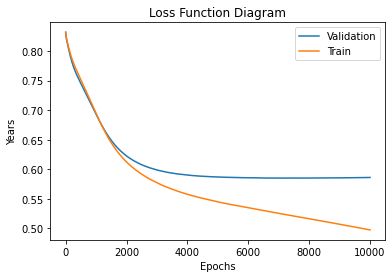

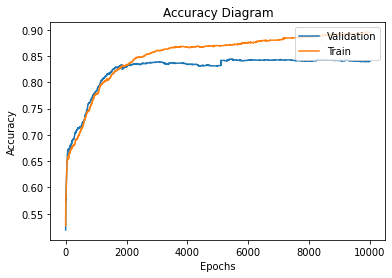

ACC on Test Data  0.845


In [221]:
DIM_I = 64
DIM_II = 2
rate = 1

myNet = NeuralNet()
myNet.addLayer(_inputDim = np.shape(trainDataPC)[1], _outputDim = DIM_I, _activFnc = LeakyReLU(), 
              _initialWeightsRange = INITWEIGHTS)
myNet.addLayer(_inputDim = DIM_I, _outputDim = DIM_II, _activFnc = SoftMax(), 
              _initialWeightsRange = INITWEIGHTS)
myNet.compile(_decayRate = rate, _learningRate = 0.001, _bachSize = 128, _lossFnc =  NLL(), _momentum = 0.9, 
              _epochs = 10000,_earlyStopping = False, _trainSize = 0.9)
historyLossVal, lossTrian, historyValACC, historyTrainACC = myNet.fit(_dataSet = trainDataPC, _output = trainDataOutput)
plt.plot(historyLossVal, label = 'Validation')
plt.plot(np.asarray(lossTrian), label = 'Train')
plt.legend(loc = 'upper right')
plt.xlabel("Epochs")
plt.ylabel("Years")
plt.title("Loss Function Diagram")
plt.show()
plt.close()


plt.plot(historyValACC, label = 'Validation')
plt.plot(historyTrainACC, label = 'Train')
plt.legend(loc = 'upper right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Diagram")
plt.show()
plt.close()


predicted_output = np.argmax(myNet.predict(testDataPC), axis = 1)
print("ACC on Test Data ", accuracy_score(predicted_output, testDataOutput))